# Loopy and unloopy programming techniques

This notebook uses the packages and versions described in [requirements.txt](https://github.com/jpivarski/scipy2022-loopy/blob/main/requirements.txt).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Part 1: Array-oriented programming and its advantages

## What is "array-oriented programming"?

The way I'll be using the word, it's a programming paradigm, alongside paradigms like "imperative," "object-oriented," and "functional."

<br><br><br>

**In array-oriented programming, the primary data type is an array, and most functions perform one operation on all the elements in the array.**

<br><br><br>

For instance, this is _not_ array-oriented:

In [2]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
output_data = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

for i in range(len(input_data)):                                  # explicitly specifies an order of execution
    output_data[i] = input_data[i]**2                             # user says what happens to each element

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

<br><br><br>

And this is _not_ array-oriented:

In [3]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

output_data = np.fromiter(map(lambda x: x**2, input_data), int)   # still focused on the individual element "x"

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

<br><br><br>

_This_ is array-oriented:

In [4]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

output_data = input_data**2                                       # implicit indexes, no reference to individual elements

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

<br><br><br>

A bit nebulous? Perhaps, but programming language paradigms are like that. I find the word "array-oriented" to be about as useful as the word "Pythonic."

<br><br><br><br><br>

## The long history of array-oriented programming

Although other programming paradigms are more widely discussed, array-oriented programming has a long history, going back to APL.

<img src="../img/apl-timeline.svg" width="800">

<br><br><br><br><br>

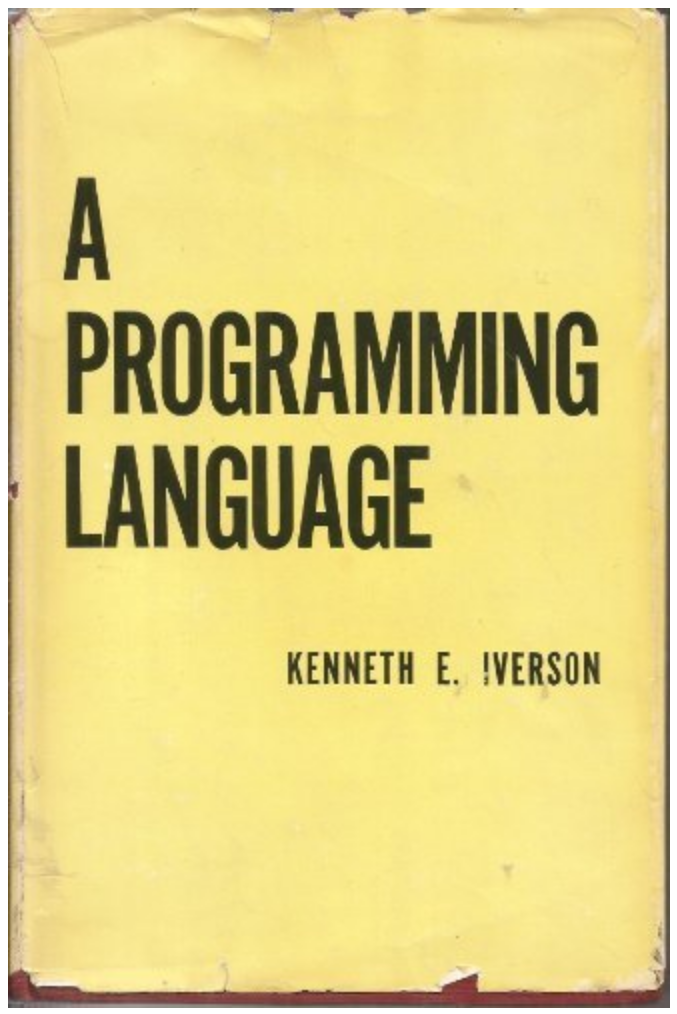
<img src="../img/apl-keyboard.jpg" width="600" style="display: inline-block; margin-right: 20px">
<img src="../img/tshirt.jpg" width="250" style="display: inline-block; margin-right: 20px">
<div style="display: inline-block">

| APL | <br> | Numpy |
|:---:|:----:|:-----:|
| <tt>ι4</tt> | <br> | <tt>np.arange(4)</tt> |
| <tt>(3+ι4)</tt> | <br> | <tt>np.arange(4) + 3</tt> |
| <tt>+/(3+ι4)</tt> | <br> | <tt>(np.arange(4) + 3).sum()</tt> |
| <tt>m ← +/(3+ι4)</tt> | <br> | <tt>m = (np.arange(4) + 3).sum()</tt> |

</div>

<br><br><br><br><br>

All of the array-oriented languages except Fortran 90 have a surprisingly common feature: they are all _interactive_ languages.

They are intended for users to tinker with, experimentally.

In retrospect, this makes sense because data analysts are often asking themselves, "What will this function do to the _distribution of all data_?"

In [5]:
dataset = np.random.normal(0, 1, 1000000)  # one MILLION data points

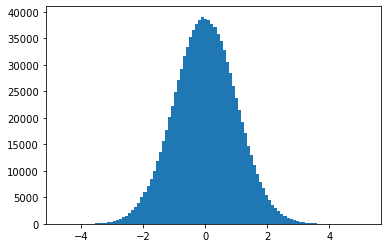

In [6]:
plt.hist(dataset, bins=100);

In [7]:
dataset2 = dataset**2

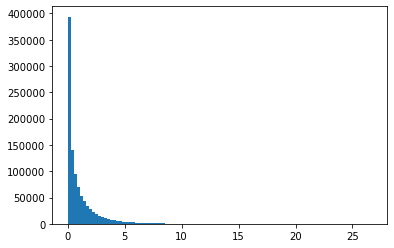

In [8]:
plt.hist(dataset2, bins=100);

In [9]:
dataset3 = np.sin(1/dataset2)

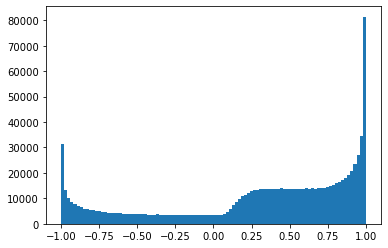

In [10]:
plt.hist(dataset3, bins=100);

<br><br><br><br><br>

**Two advantages:**

   * Mathematical expressions are more concise, more convenient to type interactively (though not as concise as APL!).
   * The right _part_ of the computation is accelerated: the loop over all data points.

<br><br><br><br><br>

## Array-oriented programming in Python: NumPy

Quick review:

<img src="../img/Numpy_Python_Cheat_Sheet.svg" width="1200">

<br><br><br><br><br>

Got that? Good!

<br><br><br><br><br>

**About interface:** NumPy makes arrays duck-typable with scalars in mathematical calculations.

In [11]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

In [12]:
a = 5
b = 10
c = -0.1

quadratic_formula(a, b, c)

0.009950493836207741

In [13]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

quadratic_formula(a, b, c)

array([ 0.00465662,  0.00466425, -0.00349206, ..., -0.00825238,
        0.00403007, -0.00127957])

<br><br><br><br><br>

**About performance:** NumPy makes each step of the calculation fast, but not necessarily the whole expression.

The `quadratic_formula` above is essentially equivalent to the following:

In [14]:
def quadratic_formula_2(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8

In [15]:
quadratic_formula(a, b, c)

array([ 0.00465662,  0.00466425, -0.00349206, ..., -0.00825238,
        0.00403007, -0.00127957])

Each of those intermediate arrays (`tmp1` through `tmp8`) has to be allocated, written to, read from, and deleted. Even without allocation/deletion, accessing new areas of RAM is slower than accessing recently accessed areas of RAM.

Compare:

In [16]:
%%timeit

quadratic_formula(a, b, c)

7.3 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit

quadratic_formula_2(a, b, c)

10.8 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(I will wave my hands about that less-than-2× difference. )

In [18]:
import numexpr

numexpr.evaluate("(-b + sqrt(b**2 - 4*a*c)) / (2*a)")                 # whole expression is calculated in a single pass over a, b, c

array([ 0.00465662,  0.00466425, -0.00349206, ..., -0.00825238,
        0.00403007, -0.00127957])

In [19]:
%%timeit

numexpr.re_evaluate()

1.08 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
import numba as nb

numba_quadratic_formula = nb.vectorize(quadratic_formula)             # compiles the function with LLVM

numba_quadratic_formula(a, b, c)

array([ 0.00465662,  0.00466425, -0.00349206, ..., -0.00825238,
        0.00403007, -0.00127957])

In [21]:
%%timeit

numba_quadratic_formula(a, b, c)

915 µs ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
import jax

def quadratic_formula_3(a, b, c):
    return (-b + jax.numpy.sqrt(b**2 - 4*a*c)) / (2*a)

jax_quadratic_formula = jax.jit(quadratic_formula_3, backend="cpu")   # compiles the function with XLA

jax_quadratic_formula(a, b, c)

DeviceArray([ 0.00465662,  0.00466432, -0.0034921 , ..., -0.00825237,
              0.00403005, -0.00127955], dtype=float32)

In [23]:
%%timeit

jax_quadratic_formula(a, b, c)

1.36 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<br><br><br><br><br>

Generally speaking,

$$\mbox{carefully optimized implementation} \hspace{0.5 cm} \ll \hspace{0.5 cm} \mbox{compiled, single-pass loop} \hspace{0.5 cm} \ll \hspace{0.5 cm} \mbox{NumPy expression} \hspace{0.5 cm} \ll \hspace{0.5 cm} \mbox{Python "for" loops}$$

<br><br><br><br><br>

## Unloopy-fu

> A language that doesn't affect the way you think about programming, is not worth knowing.

<div style="margin-left: 50px">
—— Alan Perlis
</div>

<br><br><br>

Computing an expression in which all indexes line up is one thing.

In [24]:
numbers = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [25]:
numbers - numbers

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

<img src="../img/flat-operation.svg" width="500">

But you gain even more power when you shift indexes with a slice, then compute.

In [26]:
numbers[1:] - numbers[:-1]

array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

<img src="../img/shifted-operation.svg" width="500">

<br><br><br><br><br>

How about a triangle?

In [27]:
ones = np.ones(9, int)
ones

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
ones[1:] + ones[:-1]

array([2, 2, 2, 2, 2, 2, 2, 2])

In [29]:
triangle = np.zeros(9, int)
triangle[:] += ones
triangle[1:-1] += ones[1:-1]
triangle[2:-2] += ones[2:-2]
triangle[3:-3] += ones[3:-3]
triangle[4:-4] += ones[4:-4]
triangle

array([1, 2, 3, 4, 5, 4, 3, 2, 1])

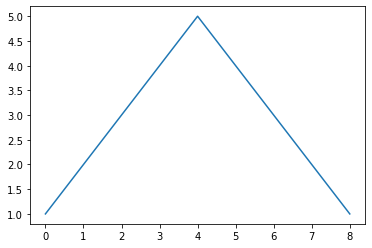

In [30]:
plt.plot(triangle);

<br><br><br><br><br>

A real-world application?

In [31]:
noisy_data = np.sin(np.linspace(0, 2*np.pi, 1000)) + np.random.normal(0, 0.5, 1000)

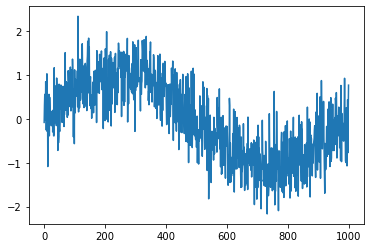

In [32]:
plt.plot(noisy_data);

In [33]:
window_smoothed = noisy_data.copy()

Repeatedly evaluate the following cell.

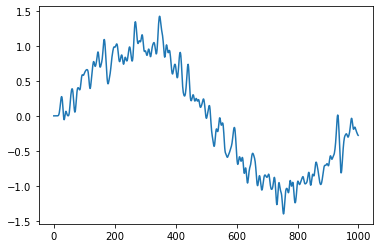

In [135]:
window_smoothed[1:] += window_smoothed[:-1]
window_smoothed /= 2

plt.plot(window_smoothed);

<br><br><br><br><br><br><br><br><br><br>

Fun aside, what you would actually do is:

In [35]:
np.lib.stride_tricks.sliding_window_view([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9], 3)

array([[1.1, 2.2, 3.3],
       [2.2, 3.3, 4.4],
       [3.3, 4.4, 5.5],
       [4.4, 5.5, 6.6],
       [5.5, 6.6, 7.7],
       [6.6, 7.7, 8.8],
       [7.7, 8.8, 9.9]])

In [36]:
np.lib.stride_tricks.sliding_window_view([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9], 3).mean(axis=1)

array([2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8])

In [37]:
noisy_data.shape

(1000,)

In [38]:
np.lib.stride_tricks.sliding_window_view(noisy_data, 30).shape

(971, 30)

In [39]:
np.lib.stride_tricks.sliding_window_view(noisy_data, 30).mean(axis=1).shape

(971,)

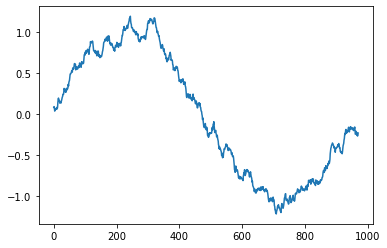

In [40]:
plt.plot(np.lib.stride_tricks.sliding_window_view(noisy_data, 30).mean(axis=1));

<br><br><br><br><br><br><br><br><br><br>

## Part 1 exercise

Go to [exercises/exercise-1.ipynb](exercises/exercise-1.ipynb) now!

<br><br><br><br><br>

# Part 2: Array-oriented programming's disadvantages

Let's suppose for a moment that SciPy did not exist and you need to calculate the log of the Gamma function,

$$\log\Gamma(z) \hspace{0.5 cm} \mbox{where} \hspace{0.5 cm} \Gamma(z) = \int_0^\infty t^{z - 1} e^{-t} \, dt$$

So you dust off your copy of [_Numerical Recipes_](http://numerical.recipes/).

<img src="../img/numerical-recipes.jpg" width="300">

Inside (page 214), you find the algorithm that you need and translate it from the Fortran or Pascal or whatever into Python:

In [41]:
def log_of_gamma(x):
    tmp = x + 5.5
    tmp -= (x + 0.5) * np.log(tmp)
    ser = 1.000000000190015
    for i, cof in enumerate([
        76.18009172947146, -86.50532032941677, 24.01409824083091, -1.231739572450155, 0.1208650973866179e-2, -0.5395239384953e-5
    ]):
        ser += cof / (x + i + 1)
    return -tmp + np.log(2.5066282746310005 * ser / x)

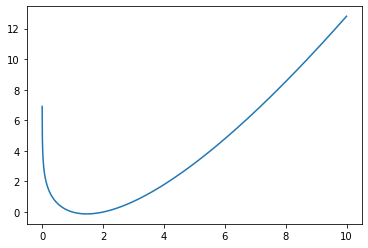

In [42]:
xs = np.linspace(0, 10, 10000)[1:]
ys = [log_of_gamma(x) for x in xs]
plt.plot(xs, ys);

Actually SciPy does exist, so we can confirm the calculation.

In [43]:
import scipy.special

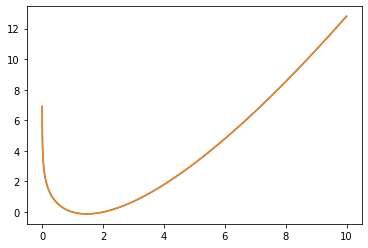

In [44]:
plt.plot(xs, ys);
plt.plot(xs, scipy.special.loggamma(xs));

<br><br><br><br><br>

The list comprehension is probably slow.

Suppose, instead of a function that takes scalar `x`, you want an array-oriented function that takes an array `xs`.

Well, you're in luck!

In [45]:
log_of_gamma(xs)

array([ 6.90707882,  6.21335683,  5.80731856, ..., 12.79732373,
       12.79957555, 12.80182748])

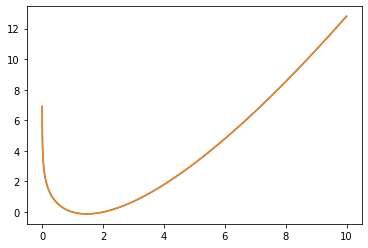

In [46]:
plt.plot(xs, log_of_gamma(xs));
plt.plot(xs, scipy.special.loggamma(xs));

<br><br><br><br><br>

That automatically worked because every `x`, `tmp`, and `ser` in

```python
def log_of_gamma(x):
    tmp = x + 5.5
    tmp -= (x + 0.5) * np.log(tmp)
    ser = 1.000000000190015
    for i, cof in enumerate([
        76.18009172947146, -86.50532032941677, 24.01409824083091, -1.231739572450155, 0.1208650973866179e-2, -0.5395239384953e-5
    ]):
        print(ser)
        ser += cof / (x + i + 1)
    return -tmp + np.log(2.5066282746310005 * ser / x)
```

can be arrays as easily as they can be scalars, as long as the shapes match (are broadcastable).

<br><br><br><br><br>

Now what if you need an incomplete gamma function $P(a, x)$?

$$P(a, x) = \frac{1}{\Gamma(a)} \int_0^x t^{a - 1} e^{-t} \, dt \hspace{0.5 cm} \mbox{where} \hspace{0.5 cm} a > 0$$

No problem; that's on page 219:

In [47]:
EPS = 3e-7

def incomplete_gamma_P(a, x):
    gln = log_of_gamma(a)

    delta = summation = 1.0 / a

    for i in range(100):
        delta *= x / (a + i + 1)
        summation += delta
        if np.absolute(delta) < np.absolute(summation) * EPS:
            return summation * np.exp(-x + a*np.log(x) - gln)

    raise Exception("did not converge")

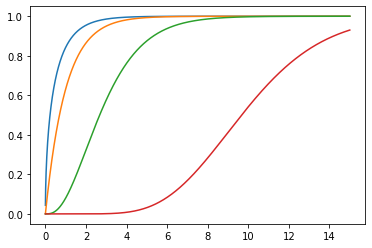

In [48]:
xs = np.linspace(0, 15, 10000)[1:]
plt.plot(xs, [incomplete_gamma_P(0.5, x) for x in xs]);
plt.plot(xs, [incomplete_gamma_P(1.0, x) for x in xs]);
plt.plot(xs, [incomplete_gamma_P(3.0, x) for x in xs]);
plt.plot(xs, [incomplete_gamma_P(10, x) for x in xs]);

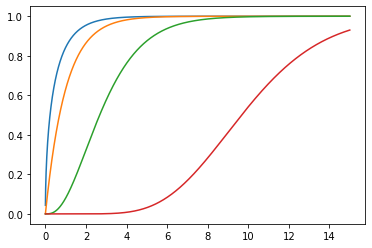

In [49]:
plt.plot(xs, scipy.special.gammainc(0.5, xs));
plt.plot(xs, scipy.special.gammainc(1.0, xs));
plt.plot(xs, scipy.special.gammainc(3.0, xs));
plt.plot(xs, scipy.special.gammainc(10, xs));

<br><br><br><br><br>

## The "iterate until converged" problem

But this one doesn't "just work" for arrays:

In [50]:
incomplete_gamma_P(3.0, xs)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

An `if` statement can't be evaluated in an array-oriented way because we can't have some values of the array enter the `if` block and others not.

This kind of "iterate until converged" is a problem for array-oriented techniques.

What do we do?

### Have all values continue to iterate, even if some have already converged?

In [51]:
def incomplete_gamma_P_numpy1(a, x):
    gln = log_of_gamma(a)

    delta = summation = 1.0 / a

    for i in range(100):
        delta *= x / (a + i + 1)
        summation += delta

    return summation * np.exp(-x + a*np.log(x) - gln)

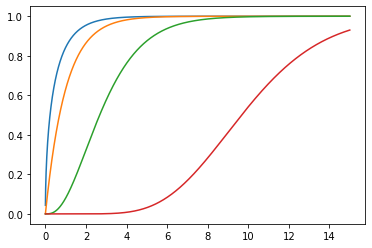

In [52]:
plt.plot(xs, incomplete_gamma_P_numpy1(0.5, xs));
plt.plot(xs, incomplete_gamma_P_numpy1(1.0, xs));
plt.plot(xs, incomplete_gamma_P_numpy1(3.0, xs));
plt.plot(xs, incomplete_gamma_P_numpy1(10, xs));

### Keep track of which values converged and don't compute those?

In [53]:
EPS = 3e-7

def incomplete_gamma_P_numpy2(a, x):
    gln = log_of_gamma(a)

    delta = np.full(x.shape, 1.0 / a)
    summation = delta.copy()

    not_converged = np.ones(x.shape, np.bool_)

    for i in range(100):
        delta[not_converged] *= x[not_converged] / (a + i + 1)
        summation[not_converged] += delta[not_converged]
        not_converged &= np.absolute(delta) >= np.absolute(summation) * EPS

    return summation * np.exp(-x + a*np.log(x) - gln)

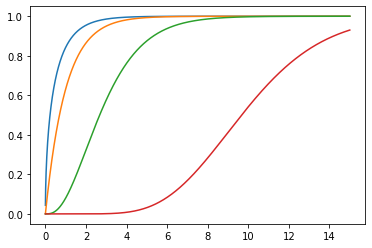

In [54]:
plt.plot(xs, incomplete_gamma_P_numpy2(0.5, xs));
plt.plot(xs, incomplete_gamma_P_numpy2(1.0, xs));
plt.plot(xs, incomplete_gamma_P_numpy2(3.0, xs));
plt.plot(xs, incomplete_gamma_P_numpy2(10, xs));

<br><br><br><br><br>

It's certainly simpler to let them all converge! The book-keeping is tricky.

But... which one's faster?

In [55]:
%%timeit

incomplete_gamma_P_numpy1(3.0, xs)

832 µs ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [56]:
%%timeit

incomplete_gamma_P_numpy2(3.0, xs)

2.37 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The _easy_ one is faster!

Sometimes (oftentimes), it's better to let an algorithm run unnecessary calculations than to maintain structures to prevent it.

<br><br><br><br><br><br><br><br><br><br>

## Part 2 exercise

Go to [exercises/exercise-2.ipynb](exercises/exercise-2.ipynb) now!

<br><br><br><br><br>

# Intermezzo: Array-oriented programming as vectorization

Go to [Google Colab:mandelbrot-on-all-accelerators.ipynb](https://drive.google.com/file/d/1J0l5e0NZm5kEm5BEUDG4neN5EN0VVCnt/view?usp=sharing) now!

<br><br><br><br><br>

# Part 3: Arbitrary data structures in array-oriented programming

So far, all of the arrays we've dealt with have been rectangular.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/8-layer_cube.jpg" width="400">

What about other data structures? What if we want variable-length lists or nested records or something?

```python
[
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
]
```

(The array above contains lists of records with fields `"x"` and `"y"`; the `"x"` field has floating point numbers and the `"y"` field has lists of integers.)

<br><br><br>

Interactive, array-oriented languages are fast because they launch precompiled routines on data that are densely packed in memory. It would seem like this could _only_ work for rectangular arrays.

Until about 5 years ago, that was the case.

## Apache Arrow

<img src="https://svn.apache.org/repos/asf/comdev/project-logos/originals/arrow.svg" width="400">

Apache Arrow is a _columnar_ format for data in memory that is capable of complex data structures.

In [57]:
import pyarrow as pa

In [58]:
arrow_array = pa.array([
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
])

In [59]:
arrow_array

[
  -- is_valid: all not null
  -- child 0 type: double
    [
      1.1,
      2.2,
      3.3
    ]
  -- child 1 type: list<item: int64>
    [
      [
        1
      ],
      [
        1,
        2
      ],
      [
        1,
        2,
        3
      ]
    ],
  -- is_valid: all not null
  -- child 0 type: double
    []
  -- child 1 type: list<item: int64>
    [],
  -- is_valid: all not null
  -- child 0 type: double
    [
      4.4,
      5.5
    ]
  -- child 1 type: list<item: int64>
    [
      [
        1,
        2,
        3,
        4
      ],
      [
        1,
        2,
        3,
        4,
        5
      ]
    ]
]

In [60]:
arrow_array.to_pylist()

[[{'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}, {'x': 3.3, 'y': [1, 2, 3]}],
 [],
 [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

<br><br><br>

You can do _some_ NumPy-like operations on it.

In [61]:
arrow_array[1:].to_pylist()

[[], [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

In [62]:
arrow_array.take([0, 2]).to_pylist()

[[{'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}, {'x': 3.3, 'y': [1, 2, 3]}],
 [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

<br><br><br>

Internally, the data structure is a collection of densely packed buffers.

The boundaries between lists and the record field names are a high-level view of this low-level information.

In [63]:
arrow_array.buffers()

[None,
 None,
 None,
 None,
 None,

In [64]:
np.frombuffer(arrow_array.buffers()[1], np.int32)

array([0, 3, 3, 5], dtype=int32)

In [65]:
np.frombuffer(arrow_array.buffers()[4], np.float64)

array([1.1, 2.2, 3.3, 4.4, 5.5])

In [66]:
np.frombuffer(arrow_array.buffers()[6], np.int32)

array([ 0,  1,  3,  6, 10, 15], dtype=int32)

In [67]:
np.frombuffer(arrow_array.buffers()[8], np.int64)

array([1, 1, 2, 1, 2, 3, 1, 2, 3, 4, 1, 2, 3, 4, 5])

<br><br><br>

The primary focus of the Arrow project is to share memory between languages and between applications:

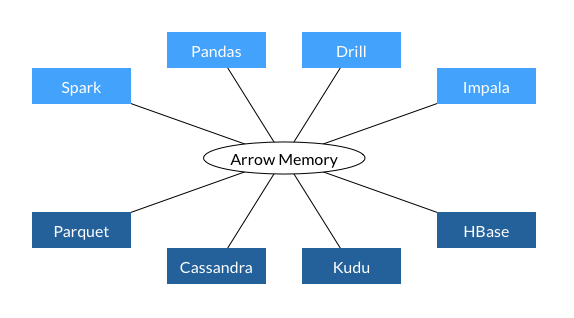

In a way that allows for faster (vectorized, CPU cache-friendly) computations:

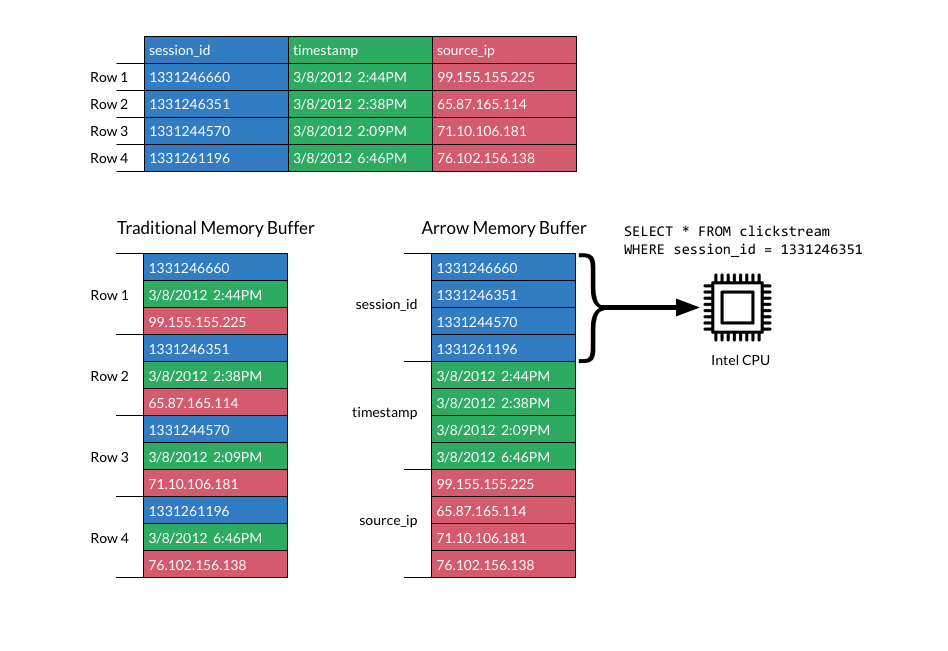

But it can be a struggle to use as a _direct_ user interface for statistical applications.

One of the tools in the Arrow ecosystem presents these arrays as generalizations of NumPy arrays.

## Awkward Array

<img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/logo/logo.svg" width="400">

(Note that `awkward._v2` is a preview of Awkward Array 2.0, which will be released in December 2022.)

In [68]:
import awkward._v2 as ak

In [69]:
awkward_array = ak.from_arrow(arrow_array)

A more concise `repr`:

In [70]:
awkward_array

<Array [[{x: 1.1, y: [1]}, ..., {...}], ...] type='3 * var * ?{x: ?float64,...'>

that can be expanded out:

In [71]:
awkward_array.show()

[[{x: 1.1, y: [1]}, {x: 2.2, y: [...]}, {x: 3.3, y: [1, 2, 3]}],
 [],
 [{x: 4.4, y: [1, 2, 3, 4]}, {x: 5.5, y: [1, ..., 5]}]]


including the data type:

In [72]:
awkward_array.type.show()

3 * var * ?{
    x: ?float64,
    y: option[var * ?int64]
}


<br><br><br>

Just as with Arrow, you can peek inside an Awkward Array to see its internal structure.

It's a tree with Arrow's `buffers` at various nodes of the tree.

In [73]:
awkward_array.layout

<ListOffsetArray len='3'>
    <offsets><Index dtype='int32' len='4'>[0 3 3 5]</Index></offsets>
    <content><UnmaskedArray len='5'>
        <content><RecordArray is_tuple='false' len='5'>
            <content index='0' field='x'>
                <UnmaskedArray len='5'>
                    <content><NumpyArray dtype='float64' len='5'>[1.1 2.2 3.3 4.4 5.5]</NumpyArray></content>
                </UnmaskedArray>
            </content>
            <content index='1' field='y'>
                <UnmaskedArray len='5'>
                    <content><ListOffsetArray len='5'>
                        <offsets><Index dtype='int32' len='6'>
                            [ 0  1  3  6 10 15]
                        </Index></offsets>
                        <content><UnmaskedArray len='15'>
                            <content><NumpyArray dtype='int64' len='15'>
                                [1 1 2 1 2 3 1 2 3 4 1 2 3 4 5]
                            </NumpyArray></content>
                        <

<br><br><br><br><br>

## Like NumPy, but for data structures

Most importantly, you can use the array as you would in NumPy.

**Slicing through a record field:**

In [74]:
awkward_array.show()

[[{x: 1.1, y: [1]}, {x: 2.2, y: [...]}, {x: 3.3, y: [1, 2, 3]}],
 [],
 [{x: 4.4, y: [1, 2, 3, 4]}, {x: 5.5, y: [1, ..., 5]}]]


In [75]:
awkward_array["x"].show()

[[1.1, 2.2, 3.3],
 [],
 [4.4, 5.5]]


**Slicing multiple dimensions at once:**

In [76]:
awkward_array["x", [True, False, True]].show()

[[1.1, 2.2, 3.3],
 [4.4, 5.5]]


In [77]:
awkward_array["x", [True, False, True], 1].show()

[2.2,
 5.5]


**Mathematical expressions on the numerical values, preserving structure:**

In [78]:
np.sqrt(awkward_array).show()

[[{x: 1.05, y: [1]}, {x: 1.48, y: ..., ...}, {x: 1.82, y: [1, ..., 1.73]}],
 [],
 [{x: 2.1, y: [1, 1.41, 1.73, 2]}, {x: 2.35, y: [1, ...]}]]


**Reductions at various levels:**

<img src="../img/example-reduction-sum.svg" width="500">

In [79]:
awkward_array["x"].show()

[[1.1, 2.2, 3.3],
 [],
 [4.4, 5.5]]


In [80]:
print(ak.sum(awkward_array["x"], axis=0))

[5.5, 7.7, 3.3]


In [81]:
ak.sum(awkward_array["x"], axis=1).show()

[6.6,
 0,
 9.9]


In [82]:
awkward_array["y"].show()

[[[1], [1, 2], [1, 2, 3]],
 [],
 [[1, 2, 3, 4], [1, 2, 3, 4, 5]]]


In [83]:
ak.sum(awkward_array["y"], axis=-1).show()

[[1, 3, 6],
 [],
 [10, 15]]


**And broadcasting (which will be used extensively in the exercise):**

In [84]:
(100 + awkward_array["y"]).show()

[[[101], [101, 102], [101, 102, 103]],
 [],
 [[101, 102, 103, 104], [101, 102, 103, 104, 105]]]


In [85]:
(awkward_array["x"] + awkward_array["y"]).show()

[[[2.1], [3.2, 4.2], [4.3, 5.3, 6.3]],
 [],
 [[5.4, 6.4, 7.4, 8.4], [6.5, 7.5, 8.5, 9.5, 10.5]]]


**Also, Awkward Array has functions that have no equivalent in rectilinear arrays:**

<table>
    <tr style="background: white; text-align: center; font-size: 18pt">
        <td>ak.cartesian</td><td>ak.combinations</td>
    </tr>
    <tr style="background: white">
        <td><img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/diagrams/cartoon-cartesian.svg" width="300"></td>
        <td><img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/diagrams/cartoon-combinations.svg" width="300"></td>
    </tr>
</table>

In [86]:
one = ak.Array([[1, 2, 3], [], [4]])
two = ak.Array([["a", "b"], ["c"], ["d", "e"]])

ak.cartesian([one, two]).show()

[[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')],
 [],
 [(4, 'd'), (4, 'e')]]


In [87]:
three = ak.Array([[1, 2, 3, 4], [], [5, 6]])

ak.combinations(three, 2).show()

[[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)],
 [],
 [(5, 6)]]


(But we won't be needing those for the exercise.)

<br><br><br><br><br>

## Comparison with pure Python

Putting this all together, array-oriented operations on data structures can be more succinct than imperative operations on the same structures.

The following selects field `"y"`, drops element `0` from each of the innermost lists (`...` to apply the slice to the last dimension), then squares the results.

In [88]:
output = np.square(awkward_array["y", ..., 1:])

output.show(type=True)

type: 3 * var * option[var * ?int64]
[[[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]]]


Below is how you'd have to do it with `for` loops.

Most of the boilerplate is breaking down and building up nested lists.

In [89]:
output = []
for sublist in awkward_array:
    tmp1 = []
    for record in sublist:
        tmp2 = []
        for number in record["y"][1:]:
            tmp2.append(np.square(number))
        tmp1.append(tmp2)
    output.append(tmp1)

output

[[[], [4], [4, 9]], [], [[4, 9, 16], [4, 9, 16, 25]]]

<br><br><br>

It also scales better with big datasets. In Python, each object is a tree of class instances containing their attributes.

In [90]:
big_list = [
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
] * 100000

In [91]:
big_array = ak.Array(big_list)

Arrow and Awkward Array data are a single tree for the whole dataset with all the numerical data in the associated `buffers`.

In [92]:
big_array.layout

<ListOffsetArray len='300000'>
    <offsets><Index dtype='int64' len='300001'>
        [     0      3      3 ... 499998 499998 500000]
    </Index></offsets>
    <content><RecordArray is_tuple='false' len='500000'>
        <content index='0' field='x'>
            <NumpyArray dtype='float64' len='500000'>[1.1 2.2 3.3 ... 3.3 4.4 5.5]</NumpyArray>
        </content>
        <content index='1' field='y'>
            <ListOffsetArray len='500000'>
                <offsets><Index dtype='int64' len='500001'>
                    [      0       1       3 ... 1499991 1499995 1500000]
                </Index></offsets>
                <content><NumpyArray dtype='int64' len='1500000'>[1 1 2 ... 3 4 5]</NumpyArray></content>
            </ListOffsetArray>
        </content>
    </RecordArray></content>
</ListOffsetArray>

Even though this array has 300000 entries, the tree has only 5 nodes. The big data are in the array `buffers`.

<img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/diagrams/example-hierarchy.svg" width="900">

<br><br><br>

Consequently, implementations can be precompiled and fast.

In [93]:
%%timeit

output = []
for sublist in big_list:
    tmp1 = []
    for record in sublist:
        tmp2 = []
        for number in record["y"][1:]:
            tmp2.append(np.square(number))
        tmp1.append(tmp2)
    output.append(tmp1)

693 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
%%timeit

output = np.square(big_array["y", ..., 1:])

10.6 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br><br><br><br><br><br><br><br><br><br>

## Part 3 exercise

Go to [exercises/exercise-3.ipynb](exercises/exercise-3.ipynb) now!

<br><br><br><br><br>

# The end!